# Analyzing WTA Pro Tennis Players Dataset

In [0]:
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

## Load, Clean and Merge Datasets

In [11]:
# merge all ranked wta players
df_rank_80 = pd.read_csv("https://raw.githubusercontent.com/JeffSackmann/tennis_wta/master/wta_rankings_80s.csv", header=None)
df_rank_90 = pd.read_csv("https://raw.githubusercontent.com/JeffSackmann/tennis_wta/master/wta_rankings_90s.csv", header=None)
df_rank_00 = pd.read_csv("https://raw.githubusercontent.com/JeffSackmann/tennis_wta/master/wta_rankings_00s.csv", header=None)
df_rank_10 = pd.read_csv("https://raw.githubusercontent.com/JeffSackmann/tennis_wta/master/wta_rankings_10s.csv", header=None)
df_rank_19 = pd.read_csv("https://raw.githubusercontent.com/JeffSackmann/tennis_wta/master/wta_rankings_current.csv", header=None)


dfs_rank = [df_rank_80, df_rank_90, df_rank_00, 
            df_rank_10, df_rank_19]

df_rank = pd.concat(dfs_rank, axis=0, sort=False, join='outer')
# rename player and country columns, added name column
df_rank = df_rank.rename(columns={0:'ranking_date',1:'rank',
                                  2: 'player_id'})
print(df_rank.shape)
df_rank.head()

(1670401, 5)


,ranking_date,rank,player_id,3,4
213374,19960226,508,207013.0,1.0,NaN
182409,20121029,953,202700.0,11.0,5.0
388966,20151228,693,211897.0,27.0,NaN
416341,19990906,493,202186.0,20.0,NaN
77863,19920622,356,200423.0,1.0,NaN


In [17]:
# load players name df
df_players = pd.read_csv("https://raw.githubusercontent.com/JeffSackmann/tennis_wta/master/wta_players.csv", encoding = "ISO-8859-1")
# renaming columns and values
df_players = df_players.rename(columns={'200000':'player_id','X':'name_first',
                                       'X.1':'name_list','U':'hand',
                                       '19000000':'birthdate','UNK':'country_id'})
# combine first and last name
df_players['name'] = df_players['name_first']+" "+df_players['name_list']
print(df_players.shape)
df_players.head()

(21750, 7)


,player_id,name_first,name_list,hand,birthdate,country_id,name
0,200001,Martina,Hingis,R,19800930.0,SUI,Martina Hingis
1,200002,Mirjana,Lucic,R,19820309.0,CRO,Mirjana Lucic
2,200003,Justine,Henin,R,19820601.0,BEL,Justine Henin
3,200004,Kerry Anne,Guse,R,19721204.0,AUS,Kerry Anne Guse
4,200005,Jolene,Watanabe Giltz,R,19680831.0,USA,Jolene Watanabe Giltz


In [21]:
# merge players name and id
wta_ranks = pd.merge(df_rank, df_players, how='inner', on='player_id')
# convert birthdate to integer first before calculating age
wta_ranks = wta_ranks.astype({"ranking_date": float}, errors='ignore')
wta_ranks['age'] = (wta_ranks['ranking_date']-wta_ranks['birthdate'])/10000
# set ranking year
wta_ranks['r_year'] = wta_ranks['ranking_date']//10000

print(wta_ranks.shape)
wta_ranks.sample(5)

(1670400, 13)


,ranking_date,rank,player_id,3,4,name_first,name_list,hand,birthdate,country_id,name,age,r_year
723562,19991108.0,166,200111.0,149.0,NaN,Lina,Krasnoroutskaya,R,19840429.0,RUS,Lina Krasnoroutskaya,15.0679,1999.0
764079,20070409.0,251,201459.0,100.0,0.0,Zi,Yan,R,19841112.0,CHN,Zi Yan,22.9297,2007.0
705382,20090629.0,703,202322.0,32.0,NaN,Maki,Arai,R,19821223.0,JPN,Maki Arai,26.9406,2009.0
1031085,20130805.0,956,202929.0,11.0,3.0,Korina,Perkovic,R,19870414.0,GER,Korina Perkovic,26.0391,2013.0
1052412,20180108.0,20,201517.0,2141.0,20.0,Magdalena,Rybarikova,R,19881004.0,SVK,Magdalena Rybarikova,29.9104,2018.0


## Trim dataset to only top 100 ranked players

In [22]:
# top 100 players all time over 10 years old
wta_100 = wta_ranks[(wta_ranks['rank']<=100)&(wta_ranks['age']>=10)]
# remove duplicates since 1984
dfs_single_100 = [wta_100[wta_100['r_year']==year].drop_duplicates(
                 ['name'], keep='last').drop_duplicates(
                 ['rank'], keep='last') for year in range(1984,2020)]
wta_100 = pd.concat(dfs_single_100, axis=0, sort=False, join='outer')
# convert integer date to proper date format
wta_100['r_date'] = wta_100['ranking_date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
print(wta_100.shape)
wta_100.sample(5)

(3460, 14)


,ranking_date,rank,player_id,3,4,name_first,name_list,hand,birthdate,country_id,name,age,r_year,r_date
80895,19941226.0,56,200559.0,27.0,NaN,Kristine,Kunce,U,19700303.0,AUS,Kristine Kunce,24.0923,1994.0,1994-12-26
1322533,20131230.0,32,202446.0,1629.0,23.0,Eugenie,Bouchard,R,19940225.0,CAN,Eugenie Bouchard,19.1005,2013.0,2013-12-30
1356109,20151228.0,90,202663.0,699.0,NaN,Magda,Linette,R,19920212.0,POL,Magda Linette,23.1016,2015.0,2015-12-28
14765,19841231.0,61,200237.0,NaN,NaN,Virginia,Wade,R,19450710.0,GBR,Virginia Wade,39.0521,1984.0,1984-12-31
106905,19881031.0,96,200491.0,8.0,NaN,Christina,Singer,U,19680727.0,GER,Christina Singer,20.0304,1988.0,1988-10-31


In [28]:
# create dataframe for average top 100 players' age
age_data = []
for year in range(1984,2019):
  df_year = wta_100[wta_100['r_year']==year]
  age_100 = df_year.age
  age_mean = age_100.mean()
  age_data.append([df_year.iloc[-1]['r_date'], age_mean])
  
wta_age_100 = pd.DataFrame(age_data,columns=['date','Average Age'])
wta_age_100.describe(include='all')

,date,Average Age
count,35,35.000000
unique,35,NaN
top,2007-12-31 00:00:00,NaN
freq,1,NaN
first,1984-12-31 00:00:00,NaN
last,2018-05-28 00:00:00,NaN
mean,NaN,23.349208
std,NaN,1.028109
min,NaN,21.644281
25%,NaN,22.715715


## Graph average age of top 100 ranked players

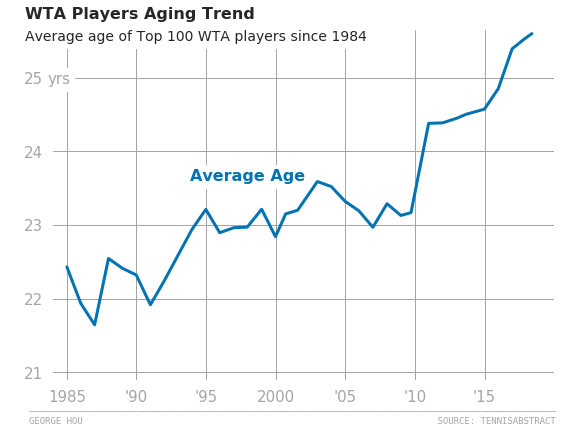

In [55]:
fig, ax = plt.subplots(figsize=(8,6))
# set plot style
plt.style.use('fivethirtyeight')

# despine outer frame
sns.set()
sns.despine(left=True, bottom=True)

# set background to white
plt.rcParams['figure.facecolor'] = 'white'
plt.grid(color='#A5A5A5')
ax.set(yticks=range(0, 50, 1), facecolor='white')

# Color palette
blue, = sns.color_palette("colorblind", 1)

# average age mean line
ax.plot(wta_age_100.date, wta_age_100['Average Age'], color=blue, lw=3)

# fill between upper std and lower bound std
# ax.fill_between(df_age_100.date, df_age_100.up_std, df_age_100.low_std, alpha=.2)

# set x and y label
ax.set_xlabel(' ',fontsize = 12,fontweight='semibold')
ax.set_ylabel(' ',fontsize = 12,fontweight='semibold')

# modify x labels
ax.set_xticks([pd.to_datetime('1985-1-1'), pd.to_datetime('1990-1-1'), 
               pd.to_datetime('1995-1-1'), pd.to_datetime('2000-1-1'), 
               pd.to_datetime('2005-1-1'), pd.to_datetime('2010-1-1'), 
               pd.to_datetime('2015-1-1')])
ax.set_xticklabels(labels=["1985","'90","'95","2000","'05","'10","'15"], 
                   fontsize=13, color='#A5A5A5')

# set x and y limits
ax.set_xlim([pd.to_datetime('1984-1-1'), pd.to_datetime('2019-12-31')])
ax.set_ylim([20.9, 25.65])

# change size and color of tick labels, extend grid
plt.tick_params(axis='x',labelsize=15,labelcolor='#A5A5A5', 
               color = '#A5A5A5')
plt.tick_params(axis = 'y', labelsize = 15, labelcolor = '#A5A5A5')

# Text for Title
ax.text(x=pd.to_datetime('1982-1-1'), y=25.8, s="WTA Players Aging Trend", 
        fontsize=16, fontweight='bold');

# Text for Subtitle
ax.text(x=pd.to_datetime('1982-1-1'), y=25.50,backgroundcolor = 'white',
        s="Average age of Top 100 WTA players since 1984", fontsize=14);

# text for yrs next to 40
ax.text(x=pd.to_datetime('1983-8-1'), y=24.915, s="yrs", fontsize=15, 
        color='#A5A5A5',backgroundcolor = 'white')

# text for average age
ax.text(x=pd.to_datetime('1993-10-30'), y=23.6, s="Average Age", fontsize=16, 
        color=blue, fontweight='semibold',backgroundcolor = 'white')

# signature line at bottom
ax.text(x =pd.to_datetime('1982-4-1'), y=20.5,
    s = '__________________________________________________________________________________________________',
    fontsize = 9, family='monospace', color = '#A5A5A5')
ax.text(x =pd.to_datetime('1982-4-1'), y=20.3,
    s = 'GEORGE HOU                                                                  SOURCE: TENNISABSTRACT',
    fontsize = 9, family='monospace', color = '#A5A5A5')

# bold y axis at 0
ax.axhline(y=0, color='black', linewidth=1.5, alpha=0.5)